# Actor determination method 1: Skimming threat reports
This notebook depicts the first methodology for actor determination as described in the corresponding master thesis. Threat reports are used as a basis for determining active threats and actors over a period in time.
The results of skimming the reports are denoted in a spreadsheet, which is scanned and used to count the precise occurences of these threats and actors across the reports. This data is then further enriched using public data sources. A graphical representation is depicted in the image below.

The enriched data can then be filtered on the sector and the actors and TTPs will be ranked using the ranking functions. These ranked TTPs are then mapped to controls in order to obtain a prioritization of security controls.

![Diagram representation of method 1](./docs/images/Method1.png)

## 1. Determine relevant threats  and actors
### 1.1. Scan spreadsheet with skimming results 
#### 1.1.1. Build actor and threat list

In [2]:
import pandas as pd

SECTOR = 'Government'
YEAR = 2021

file = "Threat reports.xlsx"
reports = pd.read_excel(file,sheet_name="Threat reports")

In [3]:
# Function to transform a list to unique (case insensitive) values
def unique(lst):
    result=[]
    marker = set()

    for l in lst:
        ll = l.lower()
        if ll not in marker:   # test presence
            marker.add(ll)
            result.append(l)   # preserve order

    return result

# Build the lists

# Filter on one year
reports=reports[reports['reported year'] == YEAR]

report_threats = reports['threats'].dropna().apply(lambda x: x.split(", "))
threats_mentions = pd.Series([t for l in report_threats for t in l if t != ""])
threatlist = unique(threats_mentions)

report_actors = reports['actors'].dropna().apply(lambda x: x.split(", "))
actor_mentions = pd.Series([t for l in report_actors for t in l if t != ""])
actorlist = unique(actor_mentions)

print(len(threatlist),"Threats:\n",threatlist)
print(len(actorlist),"Threat actors:\n",actorlist)

34 Threats:
 ['ransomware', 'crypto malware', 'scams', 'adware', 'fleeceware', 'phishing', 'coinminers', 'information stealers', 'remote access trojan', 'technical support cams', 'rootkits', 'supply chain attack', 'remote code execution', 'business email compromise', 'brand abuse', 'data exposure on code repositories', 'targeted threats on remote work', 'DDoS', 'proxy shell', 'account compromise', 'system compromise', 'botnet', 'server access', 'credential harvesting', 'misconfiguration', 'malicious insider', 'vulnerability exploitation', 'brute force', 'password spraying', 'banking trojan', 'network pivot', 'network infrastructure compromise', 'local code execution', 'use of stolen credentials']
73 Threat actors:
 ['LuckyMouse', 'Mustang Panda', 'Gamaredon', 'Promethium', 'HAFNIUM', 'Wizard Spider', 'Bitwise Spider', 'Carbon Spider', 'Pinchy Spider', 'Pioneer Kitten', 'Deus', 'BlackShadow', 'Moses Staff', 'Nemesis Kitten', 'Wicked Panda', 'Doppel Spider', 'Aquatic Panda', 'Fancy Bear'

#### 1.1.2. Visualize quarterly time coverage

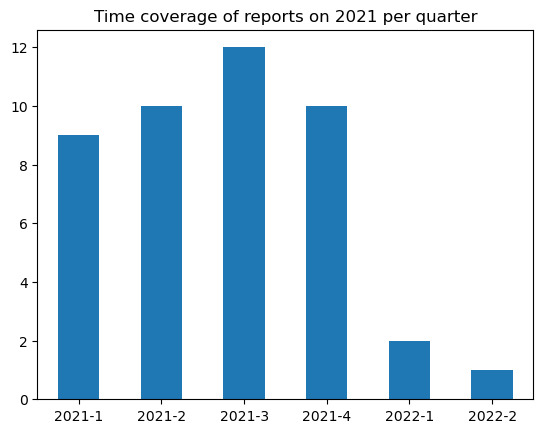

In [4]:
# Convert a 2d list to 1d
def to_1D(series):
 return pd.Series([x for _list in series for x in _list if len(x) > 1]) # Convert column of lists to one list and remove single character values

quarters = to_1D(reports['quarter'].dropna().apply(lambda x: x.split(", "))).value_counts().sort_index()
fig = quarters.plot(kind='bar',rot=0, title='Time coverage of reports on {} per quarter'.format(YEAR))

#### Observations
It can be seen that not all reports report on a full calendar year. Some reports do not start in Q1, but start in Q3 and report on the following 4 quarters, like the ENISA threat landscape. In other cases, the report does not report on 4 quarters. For example, Bugcrowd reports up and until Q3, since the report is released before the end of the year.

### 1.2. Scan PDFs on threats and actors
Scan the PDFs on the actors and threats from the spreadsheet and count the number of occurences.

#### 1.2.1. Initialize dictionaries and functions
Initialize dictionaries and define a preprocessing function whichs converts to lowercase and removes punctuations. 

In [5]:
import os
import re

report_folder = "reports\\2021"
report_list = [file for file in os.listdir(report_folder) if file.endswith(".pdf")]

## Init threat dictionary to count occurences of threats per report
report_threats = {}  
report_actors = {}

for i in report_list:
    threat_dict = {}
    for j in threatlist:
        threat_dict[j] = 0    
    report_threats[i] = threat_dict

for i in report_list:
    actor_dict = {}
    for k in actorlist:
        actor_dict[k] = 0
    report_actors[i] = actor_dict

def preprocess(text):
    text_lower = re.sub(r"[^a-zA-Z0-9 ]","",text.lower())
    return text_lower

#### 1.2.2. Build dictionary with contents of PDFs
The text of the PDFs is saved as both the original as well as the preprocessed text.

In [6]:
import PyPDF2

text_dict = {}

for file in report_list:
    print("Processing: ",file)

    reader = PyPDF2.PdfFileReader(report_folder+"\\"+file,strict=False)
    raw_text = ""
    for page_number in range(0, reader.numPages):
        page = reader.getPage(page_number)
        raw_text += page.extractText()
    text_dict[file] = {"raw": raw_text, "processed": preprocess(raw_text)}

Processing:  Blackberry.pdf
Processing:  Bugcrowd.pdf
Processing:  Crowdstrike.pdf
Processing:  CTM360.pdf
Processing:  Deepwatch.pdf
Processing:  ENISA.pdf
Processing:  Fortinet-2021H1.pdf
Processing:  Fortinet-2021H2.pdf
Processing:  IBM.pdf
Processing:  Microsoft.pdf
Processing:  PaloAltoNetworks.pdf
Processing:  Rapid7.pdf
Processing:  Verizon.pdf


#### 1.2.3. Convert reports to .txt for later testing

In [7]:
from pathlib import Path

txt_filepath = Path("reports_txt/"+str(YEAR))

for file,values in text_dict.items():
    text = values["raw"]
    filenm = file.replace(".pdf",".txt")
    to_write = txt_filepath / filenm
    with open(to_write,'w',encoding='utf-8') as f:
        f.write(text)

#### 1.2.4. Count occurences of terms in reports

In [8]:
# Count occurences of terms in reports
for file,values in text_dict.items():
    text = values["processed"]
    for threat in threatlist:
        report_threats[file][threat] = text.count(threat.lower())
    for actor in actorlist:
        report_actors[file][actor] = text.count(actor.lower()) 

threats_df = pd.DataFrame(report_threats)
actors_df = pd.DataFrame(report_actors)

### 1.3. Process data and first enrichment
#### 1.3.1. Gather data from public sources
Since actors are known by a variety of names, it is important to be aware of their synonyms. Therefore the results of the same actors are summed by combining the synonyms. This information is retrieved from the [ETDA Threat Actor Encyclopedia](https://apt.etda.or.th/cgi-bin/aptgroups.cgi).

In [9]:
# Get synonyms of threat actors from ETDA
import pandas as pd
import requests

# Retrieve data in json format
etda_actors = requests.get('https://apt.etda.or.th/cgi-bin/getcard.cgi?g=all&o=j')
data = etda_actors.json()

actor_list = []

for actor in data['values']:
    actor_dict = {}
    actor_dict['actor'] = actor['actor']
    actor_dict['alternate_names'] = [x['name'] for x in actor['names']]
    actor_list.append(actor_dict)

synonym_df = pd.DataFrame(actor_list)
synonym_df

,actor,alternate_names
0,Big Panda,[Big Panda]
1,Boulder Bear,[Boulder Bear]
2,Clockwork Spider,[Clockwork Spider]
3,Corsair Jackal,"[Corsair Jackal, TunisianCyberArmy]"
4,Dextorous Spider,[Dextorous Spider]
...,...,...
424,UNC1878,[UNC1878]
425,[Vault 7/8],[[Vault 7/8]]
426,Yanbian Gang,[Yanbian Gang]
427,Yingmob,[Yingmob]


#### 1.3.2. Merge results of synonyms from actors

In [10]:
# Transpose dataframe so that the actors are columns
actors_df_transposed = actors_df.T

# Function to find synonyms of actors and sum the results
def sum_synonyms(df, synonyms):
    summed_df = df
    word_matches = {}
    for actor in df.columns:
        # lst = []
        for _, row in synonyms.iterrows():
            keyname = row['actor']
            synonym = row['alternate_names']
            match = [x for x in synonym if actor == x]
            if actor == keyname or match:
                match = ' '.join(map(str, match))
                try:
                    word_matches[keyname].append(match)
                except:
                    word_matches[keyname] = [match]

    # Combine results of alternative names
    for keyname, matches in word_matches.items():
        summed_df[keyname] = df[matches].sum(axis=1)
    
    # Return the summed columns
    return summed_df[list(word_matches.keys())]

actors_df = sum_synonyms(actors_df_transposed,synonym_df).T


#### 1.3.3. Normalize data and plots
Since the absolute number of hits cannot be compared between reports, due to differences in report lengths and the number of words, the data is normalized using the minmax normalization. The resulting number depicts how relatively often this threat or actor is mentioned within the report. The assumption is that the more often a threat is mentioned, the more important it is deemed. 

In [11]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

normalized_threats = normalize(threats_df)
normalized_actors = normalize(actors_df)

<AxesSubplot:>

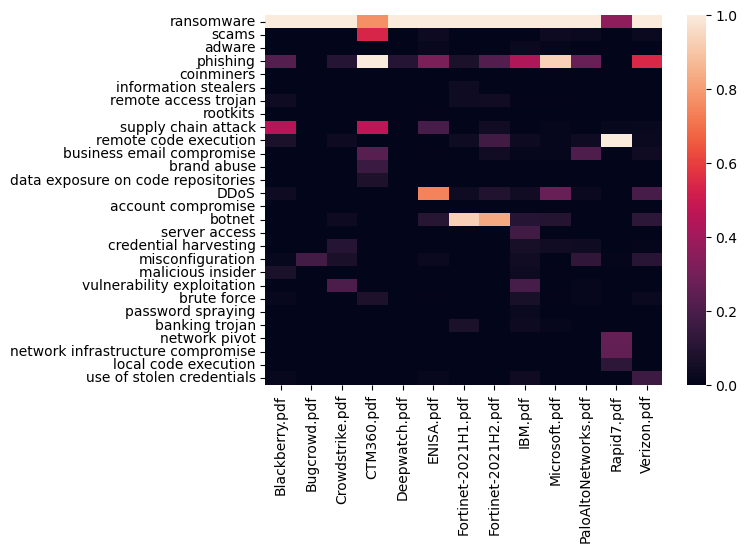

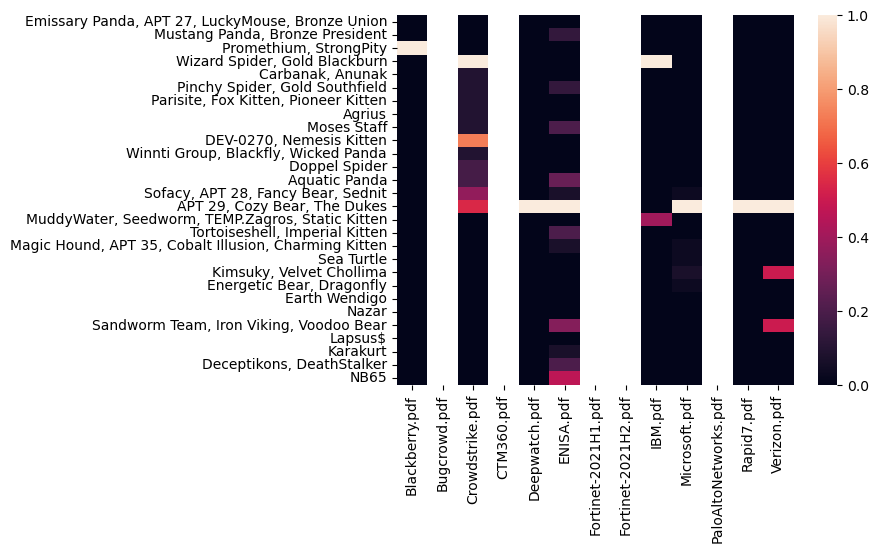

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure()
sns.heatmap(normalized_threats.loc[~(normalized_threats==0).all(axis=1)], yticklabels=True)

plt.figure()
sns.heatmap(normalized_actors.loc[~(normalized_actors==0).all(axis=1)], yticklabels=True)


# fig = plt.figure()
# threat_occurences = normalized_threats.gt(0).sum(axis=1)
# threat_occurences.sort_values(inplace=True)
# threat_occurences.nlargest(10).plot(kind="bar",title="Top 10 threats occuring in threat reports")
# plt.ylabel("Number of reports reporting on threat")
# plt.show()

#### Observations
It can be seen that Ransomware is mentioned in every report. IBM and CTM360 mention a wide variety of threats.

Not all reports report on threat actors, 8 out of 13 reports are mentioning threat actors. ENISA and Crowdstrike are doing this the most. APT29, a group attributed to Russia's Foreign Intelligence Service, is mentioned the most.

#### 1.3.3. Sum counts
The normalized counts per report are summed for the threats and actors, as well as the number of reports the term occurs in. 

In [13]:
total_count = normalized_actors.sum(axis=1)
reports_mentioned = normalized_actors.gt(0).sum(axis=1)

actors_results = pd.concat([total_count,reports_mentioned],axis=1)
actors_results.columns = ['total_count','reports_mentioned']

print(actors_results.shape)
actors_results.sort_values(by='total_count',ascending=False)

(28, 2)


,total_count,reports_mentioned
"APT 29, Cozy Bear, The Dukes",5.545455,6
"Wizard Spider, Gold Blackburn",2.000000,2
"Promethium, StrongPity",1.000000,1
"Sandworm Team, Iron Viking, Voodoo Bear",0.833333,2
"DEV-0270, Nemesis Kitten",0.727273,1
"Kimsuky, Velvet Chollima",0.566667,2
NB65,0.466667,1
"Sofacy, APT 28, Fancy Bear, Sednit",0.463636,3
Aquatic Panda,0.448485,2
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",0.400000,1


#### Observations:
From the summed results can be seen that APT29 is mentioned the most by a big margin. There are 8 reports mentioning threat actors, and this actor appears in 6.

Some actors are present in the list but have no occurences in the reports. This can be explained by the initial spreadsheet. Some reports are described of which no PDF is present. This is the case for online reports, existing only as a web page.

### 1.4 Enrich data further
#### 1.4.1 Add sector and TTP data
Perform an outer join with the extracted actors and extra data from ETDA and MITRE. These two have been combined in a dataset byh tropChaud, which will be used for this. See [tropChaud.ipynb](tropChaud.ipynb) for exploration and functions for this data.

Since in some cases MITRE had two different group IDs for the same ETDA actor, these TTPs are merged for the same ETDA actor. Within the TTP lists the duplicates are removed.

In [14]:
import pandas as pd

df = pd.read_json('Categorized_Adversary_TTPs.json')
print(df.columns)

enrich_columns = ['etda_name','victim_industries','mitre_attack_ttps']

# Define helper functions

# Retrieve information on an actor
def get_actor_ETDA(actor):
   return df.loc[df['etda_name'] == actor]
                                      
# Retrieve information on a list of actors
def get_actor_list_ETDA(actor_list):
   return df.loc[df['etda_name'].isin(actor_list)]

# Get all industries
def get_industries():
    return to_1D(df['victim_industries']).value_counts().index.to_list()

extracted_actors = actors_results.index.tolist()
actors_extradata = get_actor_list_ETDA(extracted_actors)

actors_extradata = actors_extradata[enrich_columns]
actors_extradata.set_index('etda_name',inplace=True)

actors_enriched = pd.merge(actors_results,actors_extradata,how='left',left_index=True,right_index=True)
actors_enriched.index.name = 'etda_actor_name'


actors_enriched = actors_enriched.groupby(['etda_actor_name']).agg({'total_count': 'first', 'reports_mentioned': 'first', 'victim_industries':'first','mitre_attack_ttps':'sum'}) #apply(lambda df: to_1D(df['mitre_attack_ttps']))
actors_enriched['mitre_attack_ttps'] = actors_enriched['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())

actors_enriched


Index(['mitre_attack_id', 'mitre_attack_name', 'mitre_attack_aliases',
       'mitre_attack_created', 'mitre_attack_last_modified', 'mitre_url',
       'etda_id', 'etda_name', 'etda_aliases', 'etda_first_seen', 'etda_url',
       'country', 'motivation', 'victim_industries', 'victim_countries',
       'mitre_attack_ttps'],
      dtype='object')


,total_count,reports_mentioned,victim_industries,mitre_attack_ttps
etda_actor_name,,,,
"APT 29, Cozy Bear, The Dukes",5.545455,6,"[Aerospace, Defense, Education, Energy, Financ...","[T1078.004, T1001.002, T1087, T1562.004, T1560..."
Agrius,0.090909,1,None,[0]
Aquatic Panda,0.448485,2,"[Government, Technology, Telecommunications]","[T1595.002, T1027, T1003.001, T1059.003, T1588..."
"Carbanak, Anunak",0.090909,1,"[Energy, Financial, Food and Agriculture, Heal...","[T1078, T1588.002, T1036.004, T1102.002, T1036..."
"DEV-0270, Nemesis Kitten",0.727273,1,None,[0]
"Deceptikons, DeathStalker",0.200000,1,None,[0]
Doppel Spider,0.181818,1,None,[0]
Earth Wendigo,0.000000,0,None,[0]
"Emissary Panda, APT 27, LuckyMouse, Bronze Union",0.000000,0,"[Aerospace, Aviation, Defense, Education, Emba...","[T1190, T1574.001, T1059.001, T1133, T1547.001..."


#### 1.4.2 Filter on sector

In [15]:
def filter_by_sector(df, sector):
    actors_sector_exploded = df.explode('victim_industries')
    return actors_sector_exploded.loc[actors_sector_exploded['victim_industries'] == sector]

actors_filtered = filter_by_sector(actors_enriched,SECTOR)
# Remove actors that are not mentioned
actors_filtered = actors_filtered[actors_filtered['reports_mentioned']!=0]
print("Number of mentioned actors targeting this sector:",len(actors_filtered))
actors_filtered

Number of mentioned actors targeting this sector 12


,total_count,reports_mentioned,victim_industries,mitre_attack_ttps
etda_actor_name,,,,
"APT 29, Cozy Bear, The Dukes",5.545455,6,Government,"[T1078.004, T1001.002, T1087, T1562.004, T1560..."
Aquatic Panda,0.448485,2,Government,"[T1595.002, T1027, T1003.001, T1059.003, T1588..."
"Kimsuky, Velvet Chollima",0.566667,2,Government,"[T1059.001, T1594, T1136.001, T1560.001, T1562..."
"Magic Hound, APT 35, Cobalt Illusion, Charming Kitten",0.100000,2,Government,"[T1105, T1053.005, T1059.001, T1586.002, T1564..."
Moses Staff,0.290909,2,Government,"[T1105, T1587.001, T1087.001, T1505.003, T1588..."
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",0.400000,1,Government,"[T1059.007, T1057, T1087.002, T1555, T1105, T1..."
"Mustang Panda, Bronze President",0.133333,1,Government,"[T1566.002, T1573.001, T1003.003, T1546.003, T..."
"Parisite, Fox Kitten, Pioneer Kitten",0.090909,1,Government,"[T1012, T1083, T1505.003, T1046, T1190, T1036...."
"Sandworm Team, Iron Viking, Voodoo Bear",0.833333,2,Government,"[T1491.002, T1070.004, T1027, T1594, T1140, T1..."


## 2. Rank actors and TTPs
### 2.1 Rank actors
#### 2.1.1 Create weight and sort
TODO: Define weight calculation

In [16]:
actors_filtered['actor_weight'] = actors_filtered['total_count'] #TODO

actors_filtered.sort_values(by='actor_weight',ascending=False)

actors_ranked = actors_filtered[['actor_weight','mitre_attack_ttps']]
to_1D(actors_ranked['mitre_attack_ttps']).value_counts()

T1027        11
T1105        11
T1059.001    10
T1059.003    10
T1082         9
             ..
T1055.012     1
T1111         1
T1114.003     1
T1546.001     1
T1055.001     1
Length: 251, dtype: int64

<AxesSubplot:title={'center':'Top 5 actors targeting Government sector by weight'}, ylabel='etda_actor_name'>

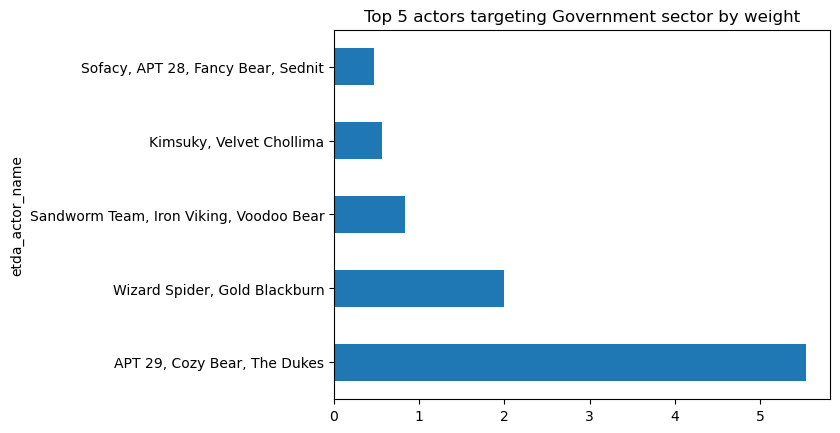

In [17]:
actor_weights = actors_ranked['actor_weight']
actor_weights.nlargest(5).plot(kind='barh',title="Top 5 actors targeting {} sector by weight".format(SECTOR))

#### Observations
Since the Government sector is the most represented in the ETDA dataset, this one is chosen for the tests. 13 of the actors from the reports target this sector. APT 29 is mentioned the most across reports. This is due to their notorious SolarWinds attack in 2020, which is mentioned often. In 2021 they also launched a big spear-phishing campaign. This actor is followed by Wizard Spider, a ransomware actor that is very active.

It is mainly these two actors that exceed the others in terms of how often they are mentioned. The other mentioned actors have a weigth just below 1.0.

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

In [18]:
actors_ttp_exploded = actors_ranked.explode('mitre_attack_ttps')

#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [19]:
actors_ttp_summed = actors_ttp_exploded.reset_index(drop=True)
ttps_ranked = actors_ttp_summed.groupby('mitre_attack_ttps').sum()
ttps_ranked.sort_values(by='actor_weight',ascending=False)

,actor_weight
mitre_attack_ttps,
T1027,10.872727
T1588.002,10.648485
T1059.001,10.581818
T1059.003,10.581818
T1082,10.318182
...,...
T1021.005,0.090909
T1059,0.090909
T1021.004,0.090909


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [20]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','kill_chain_phases','id','tactic','technique_detection','impact_type']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index
ttps_enriched['technique_name_id'] = ttps_enriched['technique'] + " (" + ttps_enriched['technique_id'] + ")"

[taxii2client.v20] [WARNING ] [2023-04-07 13:33:04,769] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-04-07 13:33:04,788] TAXII Server Response with different amount of objects! Setting per_request=737


#### 2.3.4. Calculate weights

In [21]:
ttps_enriched['ttp_weight'] = ttps_enriched['actor_weight']
ttps_enriched = ttps_enriched.drop(['actor_weight'],axis=1)

#### Statistics

<AxesSubplot:title={'center':'Top 10 techniques for actors targeting Government sector'}, ylabel='technique_name_id'>

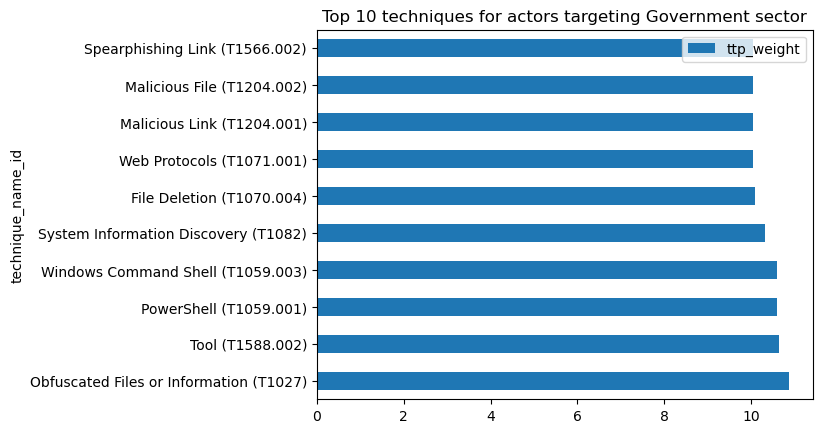

In [22]:
ttps_enriched.nlargest(10,columns='ttp_weight').plot.barh(y='ttp_weight',x='technique_name_id',title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

#### Observations
Within the tested Government sector, the top 10 techniques used are shown above. 
The top technique is '[Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/)', where adversaries obfuscate the contents of an executable or file by encrypting, encoding, compressing or otherwise obscuring them on the system or in transit. This is common behavior to evade defenses. 

The second technique is '[Tool]'(https://attack.mitre.org/techniques/T1588/002/), is described as "Adversaries may buy, steal or download software tools that can be used during targeting." This is a very generic technique, since the use of the use of tools is common among hackers and there exists a wide variety of tools, hence why it is listed in such a high position.

## 3. Control prioritization

### 3.1 Control Mapping
Source of the mapping: [Security Control Framework Mappings to ATT&CK](https://github.com/center-for-threat-informed-defense/attack-control-framework-mappings).

This maps controls from NIST 800-53 to MITRE ATT&CK. The following versions are considered:
- MITRE ATT&CK v10.1
- NIST 800-53 Revision 5

In [23]:
# Load ATT&CK to NIST 800-53 mapping
nist_attck_mapping = pd.read_excel("data/mappings/nist800-53-r5-mappings.xlsx")
nist_attck_mapping = nist_attck_mapping.drop(["Mapping Type","Technique Name"],axis=1)

In [24]:
ttp_control_merge = nist_attck_mapping.merge(ttps_enriched, left_on="Technique ID", right_on="technique_id")
ttp_control_merge.sort_values(by='ttp_weight',inplace=True,ascending=False)
ttp_control_merge

,Control ID,Control Name,Technique ID,technique_id,technique,kill_chain_phases,id,tactic,technique_detection,impact_type,technique_name_id,ttp_weight
2074,SI-4,System Monitoring,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),10.872727
2073,SI-3,Malicious Code Protection,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),10.872727
2072,SI-2,Flaw Remediation,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),10.872727
2071,CM-6,Configuration Settings,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),10.872727
2070,CM-2,Baseline Configuration,T1027,T1027,Obfuscated Files or Information,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--b3d682b6-98f2-4fb0-aa3b-b4df00...,[defense-evasion],Detection of file obfuscation is difficult unl...,NaN,Obfuscated Files or Information (T1027),10.872727
...,...,...,...,...,...,...,...,...,...,...,...,...
559,RA-5,Vulnerability Monitoring and Scanning,T1021.005,T1021.005,VNC,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--01327cde-66c4-4123-bf34-5f258d...,[lateral-movement],Use of VNC may be legitimate depending on the ...,NaN,VNC (T1021.005),0.090909
560,SC-7,Boundary Protection,T1021.005,T1021.005,VNC,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--01327cde-66c4-4123-bf34-5f258d...,[lateral-movement],Use of VNC may be legitimate depending on the ...,NaN,VNC (T1021.005),0.090909
561,SI-10,Information Input Validation,T1021.005,T1021.005,VNC,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--01327cde-66c4-4123-bf34-5f258d...,[lateral-movement],Use of VNC may be legitimate depending on the ...,NaN,VNC (T1021.005),0.090909
562,SI-15,Information Output Filtering,T1021.005,T1021.005,VNC,"[{'kill_chain_name': 'mitre-attack', 'phase_na...",attack-pattern--01327cde-66c4-4123-bf34-5f258d...,[lateral-movement],Use of VNC may be legitimate depending on the ...,NaN,VNC (T1021.005),0.090909


<AxesSubplot:ylabel='Control ID,Control Name'>

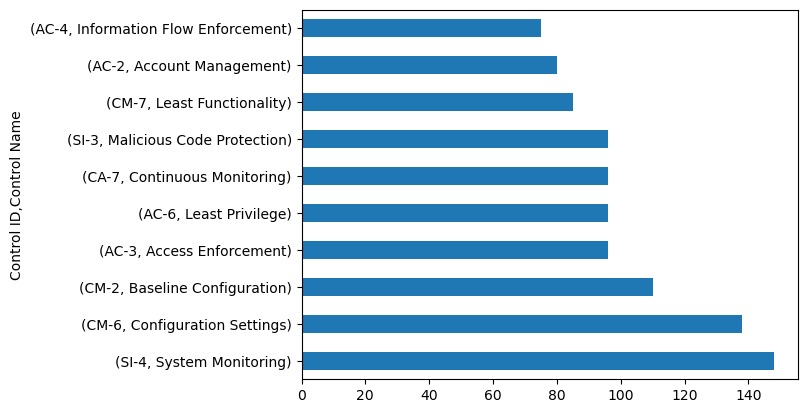

In [25]:
ttp_control_merge[['Control ID','Control Name']].value_counts().nlargest(10).plot(kind='barh')

<AxesSubplot:xlabel='Technique ID', ylabel='Control ID'>

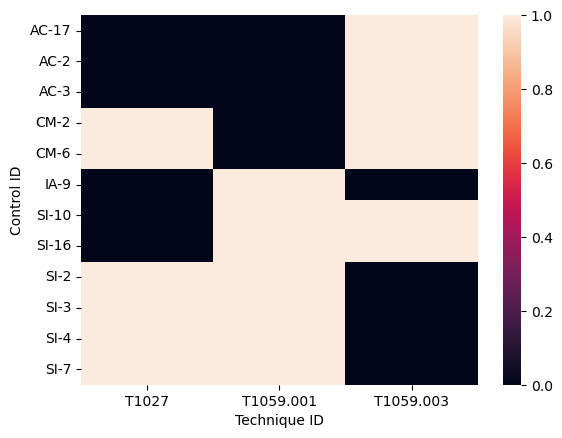

In [26]:
test_map_df = ttp_control_merge.nlargest(20,columns=["ttp_weight"])[['Control ID','Technique ID']]
df = test_map_df.groupby(['Control ID','Technique ID']).size().unstack(fill_value=0)
sns.heatmap(df)

#### Observations
There are some controls that map to a lot of TTPs. This results in a large set of TTP-Control mappings. Since there is no measure of control effectiveness to a TTP in this data, they can currently only be sorted based on the TTPs they control and their respective weights.

There are two ways to approach the ranking, either TTP based on Control based:
- TTP: Take the most prominent TTPs, which are ranked, and show the controls for this
- Control: Rank the controls based on the number of TTPs they control and their respective weights. The downside of this is that controls that map to a large number of TTPs will probably always end up on top. This means that the initial TTP ranking matters less.